# Libraries

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import CelebA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import os
import tqdm

from sklearn.manifold import TSNE

In [2]:
# set seed
seed = 8
torch.manual_seed(seed)
np.random.seed(seed)

## CelebA


In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

In [7]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:17<00:00, 129MB/s]
100% 1.33G/1.33G [00:17<00:00, 79.7MB/s]


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# !cp ./celeba-dataset.zip ./drive/MyDrive/
!cp ./drive/MyDrive/celeba-dataset.zip .

In [5]:
!unzip celeba-dataset.zip -d celeba

Streaming output truncated to the last 5000 lines.
  inflating: celeba/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197617.jpg  
  inflating

In [6]:
class CelebAAttrDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, target_trasform=None, split='train'):
        root_path = Path(root)
        self.images_path = root_path / 'img_align_celeba/img_align_celeba'
        self.attr_path = root_path / 'list_attr_celeba.csv'
        self.eval_partition_path = root_path / 'list_eval_partition.csv'
        self.transform = transform
        self.attr = self._load_attr()
        eval_partition = self._load_eval_partition()
        if split == 'all':
            partition = self.attr
        elif split == 'train':
            partition = eval_partition[eval_partition['partition'] == 0]
        elif split == 'val':
            partition = eval_partition[eval_partition['partition'] == 1]
        elif split == 'test':
            partition = eval_partition[eval_partition['partition'] == 2]
        else:
            raise ValueError('Invalid split value')

        self._set_partition(partition.index)
        self.idx2attr = {idx: attr for idx, attr in enumerate(self.attr.columns[1:])}
        self.attr2idx = {attr: idx for idx, attr in self.idx2attr.items()}

    def _set_partition(self, index):
        self.attr = self.attr.loc[index]

    def _set_attr(self, attr):
        self.attr = attr.copy()

    def _load_attr(self):
        return pd.read_csv(self.attr_path)

    def _load_eval_partition(self):
        return pd.read_csv(self.eval_partition_path)

    def __len__(self):
        return len(self.attr)

    def __getitem__(self, idx):
        img_name = self.attr.iloc[idx, 0]
        img_path = self.images_path / img_name
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        attr = self.attr.iloc[idx, 1:].values.astype(np.float32)
        return img, attr

In [7]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

celeba_dataset = CelebAAttrDataset(root='./celeba', split='train', transform=transform)

In [8]:
len(celeba_dataset), celeba_dataset[0][0].size()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(162770, torch.Size([3, 224, 224]))

Sampling groups:

In [9]:
df = celeba_dataset.attr.copy()
grouped_df = {}
for gender in [-1, 1]:
    gender_df = df[df['Male'] == gender]
    gender_name = 'man' if gender == 1 else 'woman'
    for hair_type in ['Black_Hair', 'Blond_Hair', 'Bald']:
        name = f"{gender_name}_{hair_type.split('_')[0].lower()}"
        hair_gender_df = gender_df[gender_df[hair_type] == 1]
        grouped_df[name] = hair_gender_df

[f'{group}: {len(group_df)}' for group, group_df in grouped_df.items()]

['woman_black: 18784',
 'woman_blond: 22880',
 'woman_bald: 9',
 'man_black: 20122',
 'man_blond: 1387',
 'man_bald: 3704']

# Dino

In [10]:
model_dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
model_dino.eval()

device = torch.device("cuda")
model_dino.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:10<00:00, 121MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [12]:
from torch.utils.data import DataLoader

grouped_embs = {}

for group, group_df in grouped_df.items():
    embs_list = []
    celeba_dataset._set_attr(group_df)
    celeba_dataloader = DataLoader(celeba_dataset, batch_size=128, shuffle=False)
    with torch.no_grad(), tqdm.tqdm(celeba_dataloader, total=len(celeba_dataloader)) as pbar:
        pbar.set_description(group)
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            embs = model_dino(imgs).squeeze().cpu().numpy()
            embs_list.append(embs)
    embs_list = np.concatenate(embs_list)
    grouped_embs[group] = embs_list

grouped_prototypes = {group: embs.mean(axis=0, keepdims=True) for group, embs in grouped_embs.items()}

woman_black:   0%|          | 0/147 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
man_bald: 100%|██████████| 29/29 [03:24<00:00,  7.06s/it]


In [ ]:
import pickle
with open('grouped_embs.pkl', 'wb') as f:
    pickle.dump(grouped_embs, f)
# print file size:
!ls -lh grouped_embs.pkl

In [24]:
all_embs = np.concatenate(list(grouped_embs.values()))
all_prototypes = np.concatenate(list(grouped_prototypes.values()))
y_true = np.concatenate([[i] * len(group_embs) for i, group_embs in enumerate(grouped_embs.values())])
group_names = list(grouped_embs.keys())

accuracy: 0.6731453517926024


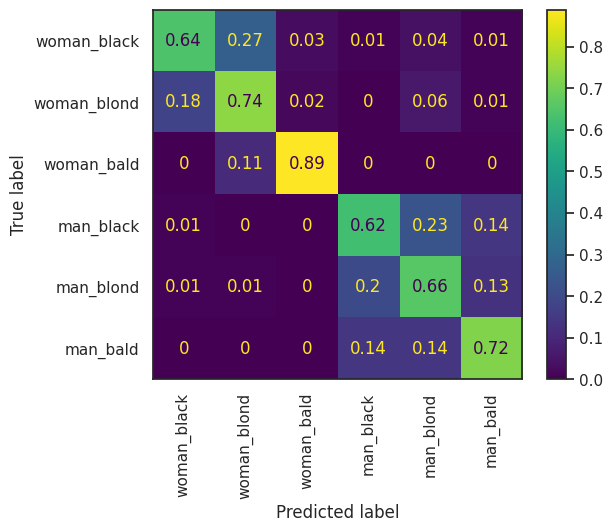

In [46]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

euc_dist = np.linalg.norm(all_embs - all_prototypes[:, None], axis=-1)
y_pred = np.argmin(euc_dist, axis=0)
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 2), display_labels=group_names)
disp.plot(xticks_rotation='vertical');
print(f'accuracy: {accuracy_score(y_true, y_pred)}')

accuracy: 0.7089674969350835


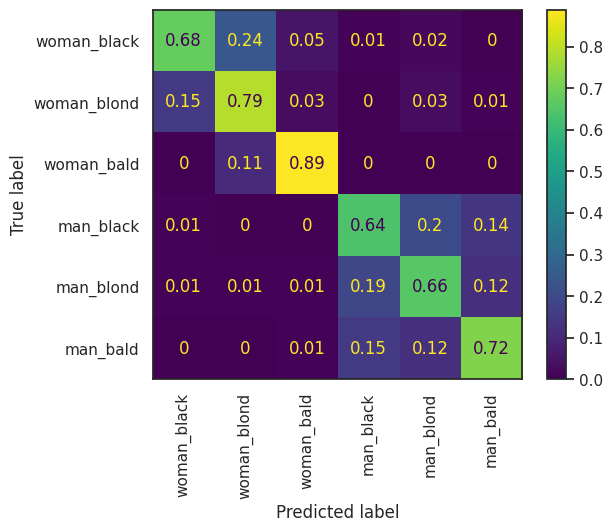

In [47]:
embs_normalized = all_embs / np.linalg.norm(all_embs, axis=-1, keepdims=True)
prototypes_normalized = all_prototypes / np.linalg.norm(all_prototypes, axis=-1, keepdims=True)
cos_dist = 1 - np.dot(embs_normalized, prototypes_normalized.T)
y_pred = np.argmin(cos_dist, axis=1)
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 2), display_labels=group_names)
disp.plot(xticks_rotation='vertical');
print(f'accuracy: {accuracy_score(y_true, y_pred)}')

accuracy: 0.6237179678856561


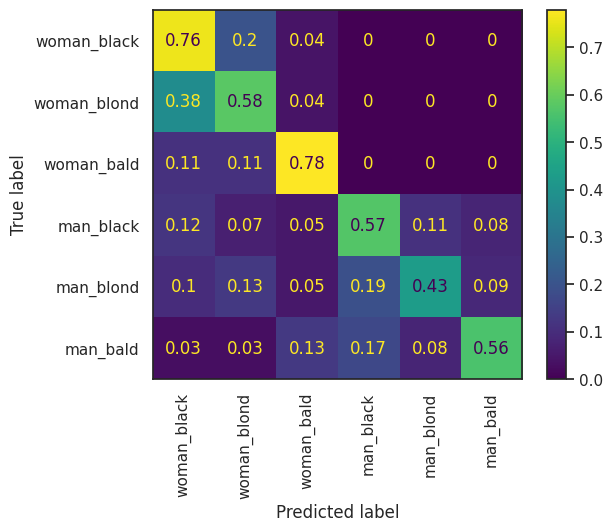

In [48]:
import utils

embs_probs = utils.softmax(all_embs)
proto_probs = utils.softmax(all_prototypes)
cross_entropy_loss = - np.dot(np.log(embs_probs), proto_probs.T)
y_pred = np.argmin(cross_entropy_loss, axis=1)
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 2), display_labels=group_names)
disp.plot(xticks_rotation='vertical');
print(f'accuracy: {accuracy_score(y_true, y_pred)}')

In [ ]:
tsne_perplexity = 30
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=tsne_perplexity)
tsne_embs = tsne.fit_transform(np.concatenate([all_embs, all_prototypes]))
# plot
plt.figure(figsize=(10, 10))
plt.scatter(tsne_embs[:, 0], tsne_embs[:, 1], c=y_true, cmap='tab10', alpha=0.5)
for i, group in enumerate(group_names):
    plt.scatter(tsne_embs[i, 0], tsne_embs[i, 1], c=f'C{i}', label=group)
plt.legend()
plt.title(f'TSNE perplexity={tsne_perplexity}')